In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

file_path = 'data_nckh.xlsx'
df = pd.read_excel(file_path)

print(df.head())

         Time  Gold_Price_VN  CPI_VN  Gold_Price_World  Oil_Price  \
0  01/01/2010         26.700    1.36           1087.50      83.25   
1  02/01/2010         26.700    1.36           1087.50      83.25   
2  03/01/2010         26.701    1.36           1087.50      83.25   
3  04/01/2010         26.760    1.36           1121.50      83.25   
4  05/01/2010         26.960    1.36           1123.25      83.25   

   Tỷ giá USD/VND  SX_CN  VN-Index  CPI_USA    SM_M2  INTEREST_RATE  \
0         18469.0    0.0    517.05      1.6  1951164          10.58   
1         18469.0    0.0    517.05      1.6  1951164          10.58   
2         18469.0    0.0    517.05      1.6  1951164          10.58   
3         18469.0    0.0    517.05      1.6  1951164          10.58   
4         18469.0    0.0    532.53      1.6  1951164          10.79   

         GSI     GSI_VN  
0  44.408702  32.921113  
1  44.408702  32.921113  
2  44.408702  32.921113  
3  44.408702  32.921113  
4  44.408702  32.921113  


In [2]:
df["Time"] = pd.to_datetime(df["Time"], format="%d/%m/%Y")
df.set_index("Time", inplace=True)

# Sắp xếp dữ liệu theo thời gian
df = df.sort_index()


In [86]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Xóa outliers nằm ngoài [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [87]:
monthly_features = ['CPI_VN (%)', 'CPI_USA (%)', 'SM_M2 (Tỷ đồng)','GSI (%)', 'GSI_VN', 'SX_CN']

# Điền dữ liệu hàng tháng bằng phương pháp forward-fill
df[monthly_features] = df[monthly_features].ffill()


In [88]:
# Tạo lag features (giá trị quá khứ)
df['Gold_Price_Lag1'] = df['Gold_Price_VN (Triệu/lượng)'].shift(1)

# Tạo trung bình động 7 ngày
df['Gold_Price_7D_MA'] = df['Gold_Price_VN (Triệu/lượng)'].rolling(window=7).mean()

# Tính % thay đổi so với ngày trước
df['Gold_Price_Pct_Change'] = df['Gold_Price_VN (Triệu/lượng)'].pct_change()

# Xóa các giá trị NaN sau khi tạo đặc trưng
df.dropna(inplace=True)


In [89]:
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['Oil_Price (USD/Thùng)', 'CPI_VN (%)', 'Tỷ giá USD/VND (VNĐ)', 
            'VN-Index', 'CPI_USA (%)', 'SM_M2 (Tỷ đồng)', 'SX_CN', 
            'INTEREST_RATE (%)', 'GSI (%)', 'GSI_VN', 'Gold_Price_Lag1', 
            'Gold_Price_7D_MA', 'Gold_Price_Pct_Change','Gold_Price_World (USD/oz)']

# Chuẩn hóa dữ liệu
df[features] = scaler.fit_transform(df[features])

# Chuẩn hóa giá vàng riêng biệt
target_scaler = MinMaxScaler(feature_range=(0, 1))
df['Gold_Price_VN (Triệu/lượng)'] = target_scaler.fit_transform(df[['Gold_Price_VN (Triệu/lượng)']])


In [90]:
df.to_csv("processed_data.csv")


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error

# Đọc dữ liệu đã xử lý
file_path = "processed_data.csv"
df = pd.read_csv(file_path, index_col="Time", parse_dates=True)


In [93]:
# Chọn các biến đầu vào (features) và biến mục tiêu (target)
features = ['Oil_Price (USD/Thùng)', 'CPI_VN (%)', 'Tỷ giá USD/VND (VNĐ)', 
            'VN-Index', 'CPI_USA (%)', 'SM_M2 (Tỷ đồng)', 'SX_CN', 
            'INTEREST_RATE (%)', 'GSI (%)', 'GSI_VN', 'Gold_Price_Lag1', 
            'Gold_Price_7D_MA', 'Gold_Price_Pct_Change','Gold_Price_World (USD/oz)']
target = 'Gold_Price_VN (Triệu/lượng)'

# Split data into train and test
train_data = df.iloc[:int(len(df) * 0.8)]
test_data = df.iloc[int(len(df) * 0.8):]

# Chuyển thành numpy array
train_values = train_data[features + [target]].values
test_values = test_data[features + [target]].values


In [94]:
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, :-1])  # Các biến đầu vào
        y.append(data[i+time_step, -1])  # Biến mục tiêu
    return np.array(X), np.array(y)

time_step = 60  # Sử dụng 60 ngày trước để dự đoán ngày tiếp theo

X_train, y_train = create_sequences(train_values, time_step)
X_test, y_test = create_sequences(test_values, time_step)


In [95]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_step, len(features))),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0161 - val_loss: 0.0477
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0011 - val_loss: 0.0336
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 9.5842e-04 - val_loss: 0.0353
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 6.3928e-04 - val_loss: 0.0267
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 5.5849e-04 - val_loss: 0.0330
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 4.5408e-04 - val_loss: 0.0300
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 3.6173e-04 - val_loss: 0.0264
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 3.6450e-04 - val_loss: 0.0276
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 3.2946e-04 - val_loss: 0.0275
Epoch 10/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 3.4791e-04 - val_loss: 0.0381
Epoch 11/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 3.2633e-04 - val_loss: 0.0275
Epoch 12/50
82/82 ━━━━━━━━

In [96]:
# Dự đoán trên tập test
predicted_prices = model.predict(X_test)

# Đưa dữ liệu về giá trị thực bằng scaler
target_scaler = MinMaxScaler()
target_scaler.fit(df[[target]])  # Fit với toàn bộ tập dữ liệu

predicted_prices = target_scaler.inverse_transform(predicted_prices)
actual_prices = target_scaler.inverse_transform(y_test.reshape(-1, 1))


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


In [97]:
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2%}")


MAPE (Mean Absolute Percentage Error): 21.41%


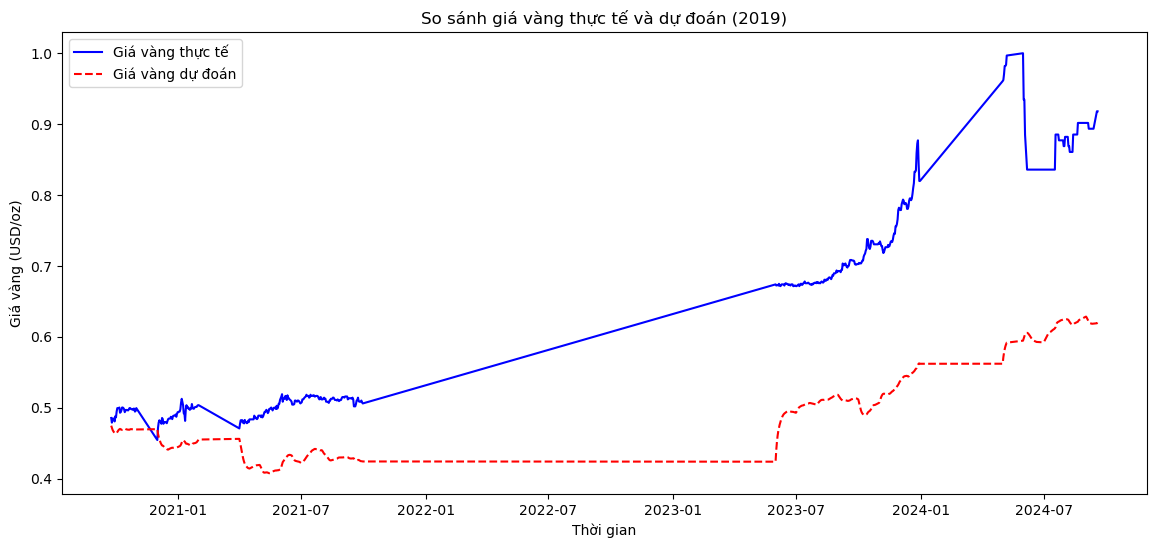

In [98]:
plt.figure(figsize=(14,6))
plt.plot(test_data.index[time_step:], actual_prices, label="Giá vàng thực tế", color='blue')
plt.plot(test_data.index[time_step:], predicted_prices, label="Giá vàng dự đoán", color='red', linestyle='dashed')
plt.xlabel("Thời gian")
plt.ylabel("Giá vàng (USD/oz)")
plt.legend()
plt.title("So sánh giá vàng thực tế và dự đoán (2019)")
plt.show()


In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Tính toán các chỉ số đánh giá mô hình
mse = mean_squared_error(actual_prices, predicted_prices)  # Sai số bình phương trung bình
rmse = np.sqrt(mse)  # Căn bậc hai của MSE
mae = mean_absolute_error(actual_prices, predicted_prices)  # Sai số tuyệt đối trung bình
r2 = r2_score(actual_prices, predicted_prices)  # Hệ số xác định R²

# In kết quả
print(f"MSE (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


MSE (Mean Squared Error): 0.0303
RMSE (Root Mean Squared Error): 0.1742
MAE (Mean Absolute Error): 0.1501
R² Score: -0.3560


In [ ]:
import pandas as pd

# Đọc dữ liệu 14 năm từ file Excel
df = pd.read_excel("gold_price_data.xlsx", parse_dates=["Time"])
df = df.sort_values("Time")  # sắp xếp theo thời gian

# Kiểm tra và xử lý dữ liệu missing/duplicate
assert df["Time"].is_unique, "Thời gian bị trùng lặp!"  # đảm bảo không trùng
assert df.isnull().sum().sum() == 0, "Có giá trị null trong dữ liệu!"  # đảm bảo không có null

# Lấy cột giá vàng Việt Nam làm biến mục tiêu, các cột khác làm đặc trưng
target_col = "Gold_Price_VN"
feature_cols = ["CPI_VN", "Gold_Price_World", "Oil_Price", "Tỷ giá USD/VN", "Chỉ số VN_Index", 
                "CPI_USA", "SM_M2", "SX_CN", "INTEREST_RATE", "GSI", "GSI_VN"]

# Chuẩn bị dữ liệu cho mô hình
features = df[feature_cols].values
target = df[target_col].values

print("Tổng số mẫu:", len(df))
print("Thời gian từ {} đến {}".format(df["Time"].min().date(), df["Time"].max().date()))
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False, 
                                                    test_size=0.2)
print("Số mẫu train:", len(X_train), " | Số mẫu test:", len(X_test))
import numpy as np

time_step = 30  # độ dài chuỗi đầu vào cho LSTM (30 ngày)

# Hàm tạo dữ liệu dạng sequence cho LSTM
def create_sequences(X, y, time_step=30):
    X_seq, y_seq = [], []
    for i in range(time_step, len(X)):
        X_seq.append(X[i-time_step:i])    # đoạn [i-time_step ... i-1]
        y_seq.append(y[i])                # giá trị tại thời điểm i (dự báo ở bước kế)
    return np.array(X_seq), np.array(y_seq)

# Tạo dữ liệu cho LSTM (sử dụng tập train)
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_step)
X_test_seq, y_test_seq = create_sequences(np.vstack([X_train[-time_step:], X_test]), 
                                         np.concatenate([y_train[-time_step:], y_test]), 
                                         time_step)
# Lưu ý: để tạo X_test_seq chính xác, nối đuôi 30 ngày cuối của train với test để không bị thiếu chuỗi
print("Shape X_train_seq:", X_train_seq.shape)  # (n_train_seq, time_step, n_features)
import tensorflow as tf
from tensorflow.keras import layers, models

# Xây dựng model LSTM đơn giản
lstm_model = models.Sequential([
    layers.LSTM(50, activation='tanh', return_sequences=False, input_shape=(time_step, X_train_seq.shape[2])),
    layers.Dense(1)  # đầu ra một giá trị (giá vàng dự báo)
])
lstm_model.compile(optimizer='adam', loss='mse')
# Huấn luyện LSTM trên dữ liệu chuỗi
history = lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, 
                         validation_split=0.1, verbose=0)
# Thêm đặc trưng lag-1 của giá vàng (giá vàng ngày trước đó)
X_rf_train = np.hstack([X_train[1:], y_train[:-1, None]])  # ghép cột giá vàng ngày trước vào features ngày hiện tại
y_rf_train = y_train[1:]
X_rf_test = np.hstack([X_test[1:], y_test[:-1, None]])
y_rf_test = y_test[1:]

from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_rf_train, y_rf_train)
# Dự báo bằng LSTM trên tập test (sử dụng X_test_seq đã chuẩn bị)
y_pred_lstm = lstm_model.predict(X_test_seq).flatten()

# Dự báo bằng RF trên tập test
y_pred_rf = rf_model.predict(X_rf_test)

# Kết hợp dự báo (weighted average)

w_lstm, w_rf = 0.7, 0.3
y_pred_ensemble = w_lstm * y_pred_lstm[-len(y_rf_test):] + w_rf * y_pred_rf  # đảm bảo độ dài tương ứng

# Nếu độ dài y_pred_lstm_seq > y_pred_rf (do cách tạo chuỗi), cắt cho khớp với RF (bỏ vài điểm đầu)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

r2 = r2_score(y_rf_test, y_pred_ensemble)
rmse = np.sqrt(mean_squared_error(y_rf_test, y_pred_ensemble))
mae = mean_absolute_error(y_rf_test, y_pred_ensemble)
print(f"Ensemble model – R^2: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

print("LSTM – R^2: %.3f, RMSE: %.3f, MAE: %.3f" % (
    r2_score(y_test_seq, y_pred_lstm), 
    np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm)), 
    mean_absolute_error(y_test_seq, y_pred_lstm)
))
print("Random Forest – R^2: %.3f, RMSE: %.3f, MAE: %.3f" % (
    r2_score(y_rf_test, y_pred_rf), 
    np.sqrt(mean_squared_error(y_rf_test, y_pred_rf)), 
    mean_absolute_error(y_rf_test, y_pred_rf)
))




KeyboardInterrupt



In [ ]:
# Dùng stacking, để huấn luyện một mô hình meta, trên y_pred_lstm và y_pred_rf so với y_test để tìm sự kết hợp tối ưu
# Sử dụng trọng số được tối ưu bằng validation